Useful links

- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
- https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
- https://towardsdatascience.com/time-series-forecasting-with-rnns-ff22683bbbb0
- https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
- https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
- http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
- https://colah.github.io/posts/2015-09-NN-Types-FP/
- https://pytorch.org/docs/stable/nn.html#rnn

In [1]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

### Download India's data

In [2]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
33,2020-03-03,1,0,0


### Italy's and Spain's data

In [3]:
it_df = pd.read_csv('csv/italy.csv')
print(it_df.sample())

es_df = pd.read_csv('csv/spain.csv')
print(es_df.sample())

          date  deceased  recovered  confirmed  active  daily
19  2020-03-11       827     1045.0      12462   10590   2313
          date   deaths  recovered  confirmed  active  daily
38  2020-04-02  10384.0      26540     126337   89413   7241


### Prep data

In [112]:
def get_rnn_dataset(series, seq_len):
    """get rnn training dataset, given a series and seq_len"""
    ip_seq = np.array(series[:-1], dtype=np.float32)
    op_seq = np.array(series[1:], dtype=np.float32)
    data_len = len(series) - 1

    ips = []
    ops = []
    for i in range(data_len - seq_len + 1):
        ip, op = ip_seq[i : i+seq_len], op_seq[i : i+seq_len]
        ips.append(ip)
        ops.append(op)
    ips = np.array(ips, dtype=np.float32)
    ops = np.array(ops, dtype=np.float32)

    # convert from numpy to torch
    ip_t = torch.from_numpy(ips)
    op_t = torch.from_numpy(ops)

    dataset = tdt.TensorDataset(ip_t, op_t)
    return dataset

# preprocess data: sma(6) and normalise by 10k
in_cnf = np.array(df['confirmed'][37:].rolling(6, center=True, min_periods=1).mean()) / 10000
it_cnf = np.array(it_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000
es_cnf = np.array(es_df['daily'].rolling(6, center=True, min_periods=1).mean()) / 10000

# Choose among India or Italy or Spain here
cnf = in_cnf # np.append(it_cnf, es_cnf)
SEQ_LEN = 5
dataset = get_rnn_dataset(cnf, SEQ_LEN)

seq_data_loader = tdt.DataLoader(dataset, shuffle=False, batch_size=1)
rnd_data_loader = tdt.DataLoader(dataset, shuffle=True, batch_size=1)

### Define NN and train

Epoch: 0 Iter:   0 Loss:  0.01219 Out: -1060.20 Ex:  37.00
Epoch: 0 Iter:  10 Loss:  0.04926 Out: -2385.47 Ex:  1453.83
Epoch: 0 Iter:  20 Loss:  0.02026 Out:  1518.48 Ex:  221.50
Epoch: 0 Iter:  30 Loss:  0.02650 Out:  2880.95 Ex:  3912.17
Epoch: 0 Iter:  40 Loss:  0.00928 Out:  1799.56 Ex:  1447.67
Epoch: 0 Iter:  50 Loss:  0.01585 Out:  3411.22 Ex:  3457.00
Epoch: 0 Iter:  60 Loss:  0.00348 Out:  1285.97 Ex:  424.17
Epoch: 1 Iter:   0 Loss:  0.01019 Out:  1502.36 Ex:  1736.33
Epoch: 1 Iter:  10 Loss:  0.01227 Out:  2603.44 Ex:  739.00
Epoch: 1 Iter:  20 Loss:  0.00838 Out:  787.47 Ex:  15.00
Epoch: 1 Iter:  30 Loss:  0.03176 Out:  5455.93 Ex:  5234.40
Epoch: 1 Iter:  40 Loss:  0.02003 Out: -837.84 Ex:  25.67
Epoch: 1 Iter:  50 Loss:  0.04938 Out:  2006.27 Ex:  4737.33
Epoch: 1 Iter:  60 Loss:  0.00150 Out:  3324.60 Ex:  3553.83
Epoch: 2 Iter:   0 Loss:  0.00410 Out:  4759.87 Ex:  4332.67
Epoch: 2 Iter:  10 Loss:  0.00078 Out:  1925.80 Ex:  1557.67
Epoch: 2 Iter:  20 Loss:  0.00353 O

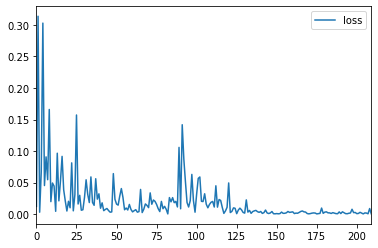

In [161]:
class Forecaster(tnn.Module):
    def __init__(self, seq_len=1, hidden_size=1, num_layers=1):
        super(Forecaster, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = tnn.RNN(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
#         self.gru = tnn.GRU(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
#         self.lstm = tnn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers)
        self.linear = tnn.Linear(self.hidden_size, 1)
        self.sigmoid = tnn.Sigmoid()
    
    def forward(self, ip, h=None):
        rnn_out, rnn_h = self.rnn(ip, h)
#         return (torch.squeeze(rnn_out), torch.squeeze(rnn_h))
        # linear layer
        final_out = []
        for i in range(self.seq_len):
            linear_out = self.linear(rnn_out[i].view(self.hidden_size))
            final_out.append(linear_out)
        return torch.stack(final_out).view(self.seq_len), rnn_h
    
    def predict(self, ip, num_predictions=1):
        preds = []
        with torch.no_grad():
            pred = ip
            h = None
            while(num_predictions):
                rnn_pred, h = self.forward(pred.view(self.seq_len, 1, 1), h)
                preds.append(pred.view(self.seq_len)[-1])
                num_predictions -= 1
        return torch.stack(preds)

HIDDEN_SIZE = 10
NUM_LAYERS=1
LEARNING_RATE = 0.1

model = Forecaster(seq_len=SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=LEARNING_RATE)

# TRAIN
loss_vals = []
pred_vals = []

NUM_EPOCHS = 3
for e in range(NUM_EPOCHS):
    for i, data in enumerate(rnd_data_loader):
        ip, op = data

        # set grads to 0
        optimizer.zero_grad()

        # predict
        pred, _ = model(ip.view(SEQ_LEN, 1, 1))

        # calc loss
        loss = loss_fn(pred, op.view(SEQ_LEN))

        # logging
        loss_vals.append(loss.item())
        if i%10 == 0:
            print("Epoch:", e, "Iter:", f"{i:3}", "Loss:", f"{loss.item(): .5f}", "Out:", f"{pred.view(SEQ_LEN)[-1].item()*10000: .2f}", "Ex:", f"{op.view(SEQ_LEN)[-1].item()*10000: .2f}")

        # assign grads
        loss.backward()

        # update weights
        optimizer.step()

df_loss = pd.DataFrame({
    'loss': loss_vals
})
df_loss.plot(
    y='loss'
)

### Test
- future values on any country's data

IN: tensor([4332.6665, 4737.3335, 4996.6665, 5234.3999, 5344.5000])
OUT: tensor([5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000, 5344.5000,
        5344.5000, 5344.5000])


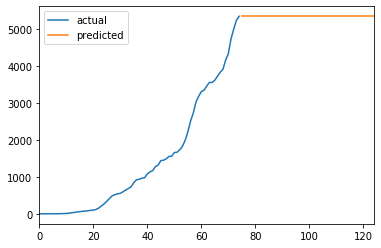

In [162]:
# CHOOSE FROM IN, IT OR ES HERE
df_cnf = in_cnf
# df_cnf = np.array([8000, 7600, 7300, 6900, 6650], dtype=np.float32) / 10000

test_in = df_cnf[-SEQ_LEN:]
t = torch.tensor(
    test_in.reshape(SEQ_LEN, 1, 1),
    dtype=torch.float32
)
print("IN:", t.view(SEQ_LEN) * 10000)
out = model.predict(t, num_predictions=50)
print("OUT:", out * 10000)

orig_df = pd.DataFrame({
    'actual': df_cnf * 10000
})
fut_df = pd.DataFrame({
    'predicted': (out.numpy() * 10000)
})
orig_df = orig_df.append(fut_df, ignore_index=True, sort=False)
_ = orig_df.plot()

- on training data

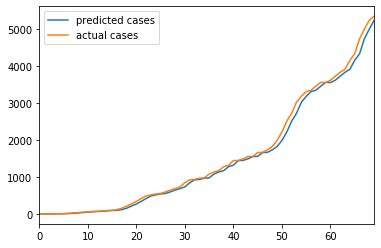

In [159]:
pred_vals = []
out_vals = []
for data in seq_data_loader:
    ip, op = data
    pred = model.predict(ip.view(SEQ_LEN, 1, 1))
    pred_vals.append(pred.item() * 10000)
    out_vals.append(op.view(SEQ_LEN)[-1].item() * 10000)

cmp_df = pd.DataFrame({
    'predicted cases': pred_vals,
    'actual cases': out_vals
})
_ = cmp_df.plot()

In [160]:
for k in model.state_dict().keys():
    print(k, "=", model.state_dict()[k])

rnn.weight_ih_l0 = tensor([[-0.6371],
        [ 0.5968],
        [-0.0933],
        [-0.0440],
        [-1.3974],
        [ 0.8414],
        [-2.7428],
        [ 0.3380],
        [ 0.0802],
        [ 0.6968],
        [-0.6180],
        [-0.8636],
        [ 0.2603],
        [ 0.3953],
        [ 0.0872],
        [-0.5592],
        [-0.7008],
        [-0.6149],
        [ 0.3586],
        [ 2.0762],
        [ 1.0527],
        [-0.2118],
        [-1.2768],
        [-2.1158],
        [-0.3032],
        [ 0.2369],
        [-0.9202],
        [ 0.4872],
        [ 0.0889],
        [-0.6648]])
rnn.weight_hh_l0 = tensor([[-5.6915e-01,  2.9490e-01, -7.5708e-02, -5.7818e-01, -3.2067e-01,
         -2.3074e-01, -2.3582e-02,  1.6171e-01,  2.9899e-01, -7.2074e-02,
         -6.1139e-01,  8.5667e-02,  1.0741e+00, -4.5105e-01,  3.5678e-02,
         -2.1646e-01, -1.0037e+00, -1.1704e+00,  6.2096e-02,  3.5398e-01,
         -6.3957e-02, -7.4166e-02, -4.6410e-01, -4.7216e-02,  9.9195e-01,
          2.3795e-01,